# Geo Time Series to Image - Solar Analytics data


---

In [1]:
# Standard libraries
import pandas as pd

# Import this package
from geots2img import ImageGenerator
from geots2img import generate_image_sequence, generate_video

# Enable modules to be reloaded during development
%load_ext autoreload
%autoreload 2

---

### Set some parameters


In [2]:
# Perth 
# LAT_RANGE = [-32, -31.8]
# LON_RANGE = [115.7, 115.9]
# GEO_RES = 0.0005

# SWIS
LAT_RANGE = [-36.05, -26.5]
LON_RANGE = [113.8, 122.4]
GEO_RES = 0.0005

---

### Load data


In [3]:
data = pd.read_pickle('../swis_ts_data/ts_image')
latlons = pd.read_pickle('../swis_ts_data/latlons')

In [4]:
print(type(data.columns[0]))
print(type(latlons.index[0]))

<class 'str'>
<class 'numpy.int64'>


In [5]:
# Columns in data (postcodes) are strings, but index of latlons (also postcodes) is int -- convert
latlons.index = latlons.index.map(str)

In [6]:
print(type(data.columns[0]))
print(type(latlons.index[0]))

<class 'str'>
<class 'str'>


In [7]:
# Quick look at data
data.iloc[5:10, 20:25]

,6028,6029,6030,6035,6036
timestamp,,,,,
2020-02-13 10:00:00+08:00,4.70,8.47,1.99,6.47,2.96
2020-02-13 11:00:00+08:00,245.60,297.94,109.65,399.50,311.77
2020-02-13 12:00:00+08:00,350.19,448.17,200.18,595.97,477.94
2020-02-13 13:00:00+08:00,407.32,559.17,280.36,693.48,605.15
2020-02-13 14:00:00+08:00,353.12,558.34,271.26,510.76,532.68


---

### Scaling

In the above snapshot of data we can see many values in different ranges.  For the image generation to work, they need to be scaled to range `[0, 1]`.  How do we do that?

For now, to do our scaling, let's use max of a rolling window over last few days.  Note that this does mean we lose the first few days of data (since we don't have a max value to scale these with).

For other applications or other datasets, we might want to do this differently.

In [8]:
# How many days do we want to look back to find max?
NUM_DAYS = 5

In [9]:
scaled = data.divide(data.rolling(24*NUM_DAYS).max())

In [10]:
# Check a few values of scaled data
scaled.iloc[24*NUM_DAYS-5:24*NUM_DAYS+4, :5]

,6000,6005,6006,6007,6008
timestamp,,,,,
2020-02-19 12:00:00+08:00,NaN,NaN,NaN,NaN,NaN
2020-02-19 13:00:00+08:00,NaN,NaN,NaN,NaN,NaN
2020-02-19 14:00:00+08:00,NaN,NaN,NaN,NaN,NaN
2020-02-19 15:00:00+08:00,NaN,NaN,NaN,NaN,NaN
2020-02-19 16:00:00+08:00,0.666872,0.704867,0.702144,0.739421,0.754173
2020-02-19 17:00:00+08:00,0.534043,0.641444,0.603088,0.610940,0.765814
2020-02-19 18:00:00+08:00,0.516805,0.704004,0.643416,0.478914,0.784326
2020-02-19 19:00:00+08:00,0.299269,0.516457,0.408457,0.322683,0.483919
2020-02-19 20:00:00+08:00,0.143215,0.265571,0.189407,0.127825,0.261895


We can see in the above that the first `NUM_DAYS` of data are lost.  Let's remove these from dataset.

In [11]:
scaled.dropna(inplace = True)

In [12]:
# Let's compare values for original data with new scaled data
start = data.index[(NUM_DAYS+1)*24+7]
end = start + pd.Timedelta(hours=5)

print(data.loc[start:end, data.columns[:5]])
print(scaled.loc[start:end, data.columns[:5]])

                             6000     6005     6006    6007     6008
timestamp                                                           
2020-02-21 12:00:00+08:00  115.62   429.89   864.57   61.99  1186.73
2020-02-21 13:00:00+08:00  249.23   820.37  1901.48  130.68  2112.53
2020-02-21 14:00:00+08:00  386.49  1363.70  2803.53  208.61  3467.08
2020-02-21 15:00:00+08:00  619.55  1854.60  3870.17  277.23  4292.56
2020-02-21 16:00:00+08:00  291.11   997.50  2048.08  150.43  2380.16
2020-02-21 17:00:00+08:00  196.02   675.24  1404.36   96.10  1562.62
                               6000      6005      6006      6007      6008
timestamp                                                                  
2020-02-21 12:00:00+08:00  0.137073  0.171735  0.154965  0.150501  0.189874
2020-02-21 13:00:00+08:00  0.295475  0.327727  0.340820  0.317269  0.338000
2020-02-21 14:00:00+08:00  0.458203  0.544781  0.502502  0.506470  0.554725
2020-02-21 15:00:00+08:00  0.734508  0.740889  0.693686  0.673068  0

In [13]:
# That all looks correct.  Let's do final sanity check, max of each column in scaled should be 1.0.
scaled.max()

6000    1.0
6005    1.0
6006    1.0
6007    1.0
6008    1.0
       ... 
6430    1.0
6432    1.0
6509    1.0
6528    1.0
6530    1.0
Length: 101, dtype: float64

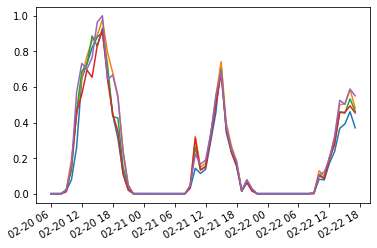

In [14]:
# We can also quickly plot a few to get a sense of the data
ax = scaled.iloc[8:8+48,:5].plot(legend=False, xlabel="");
fig = ax.get_figure()
fig.savefig('example_data.png')

In [15]:
# Let's also store the postcodes for convenience
postcodes = list(scaled.columns)
print(len(postcodes))

101


---

### Generate single image

Let's now explore some options for generating an image for one specific interval

In [16]:
# The interval for which to generate an image
DATETIME = scaled.index[15]
print(DATETIME)

2020-02-20 13:00:00+08:00


In [17]:
# Generate lists of source data points and values
source_points = []
source_values = []
for pc in postcodes:
    [lon, lat] = latlons.loc[pc, ['lon', 'lat']]
    value = scaled.loc[DATETIME, pc]
    source_points.append((lon, lat))
    source_values.append(value)

# Display five example points and values
print(source_points[5:10])
print(source_values[5:10])

[(115.80649401877928, -31.98545958419465), (115.77349423948644, -31.971699257536777), (115.75931084000678, -31.993597292741228), (115.80672212062471, -31.937710366118203), (115.76299470591694, -31.934854932829836)]
[0.6076452093331127, 0.7706751927223322, 0.7596298104926249, 0.6748932572722725, 0.9208698567801887]


In [18]:
# Create geots2img image generator object
GEO_RES = 0.005
image_gen = ImageGenerator(LON_RANGE, LAT_RANGE, GEO_RES)

In [19]:
# Set the source points and values
image_gen.set_source_points(source_points)
image_gen.set_source_values(source_values)

In [20]:
# Generate the image
image_gen.generate_image()

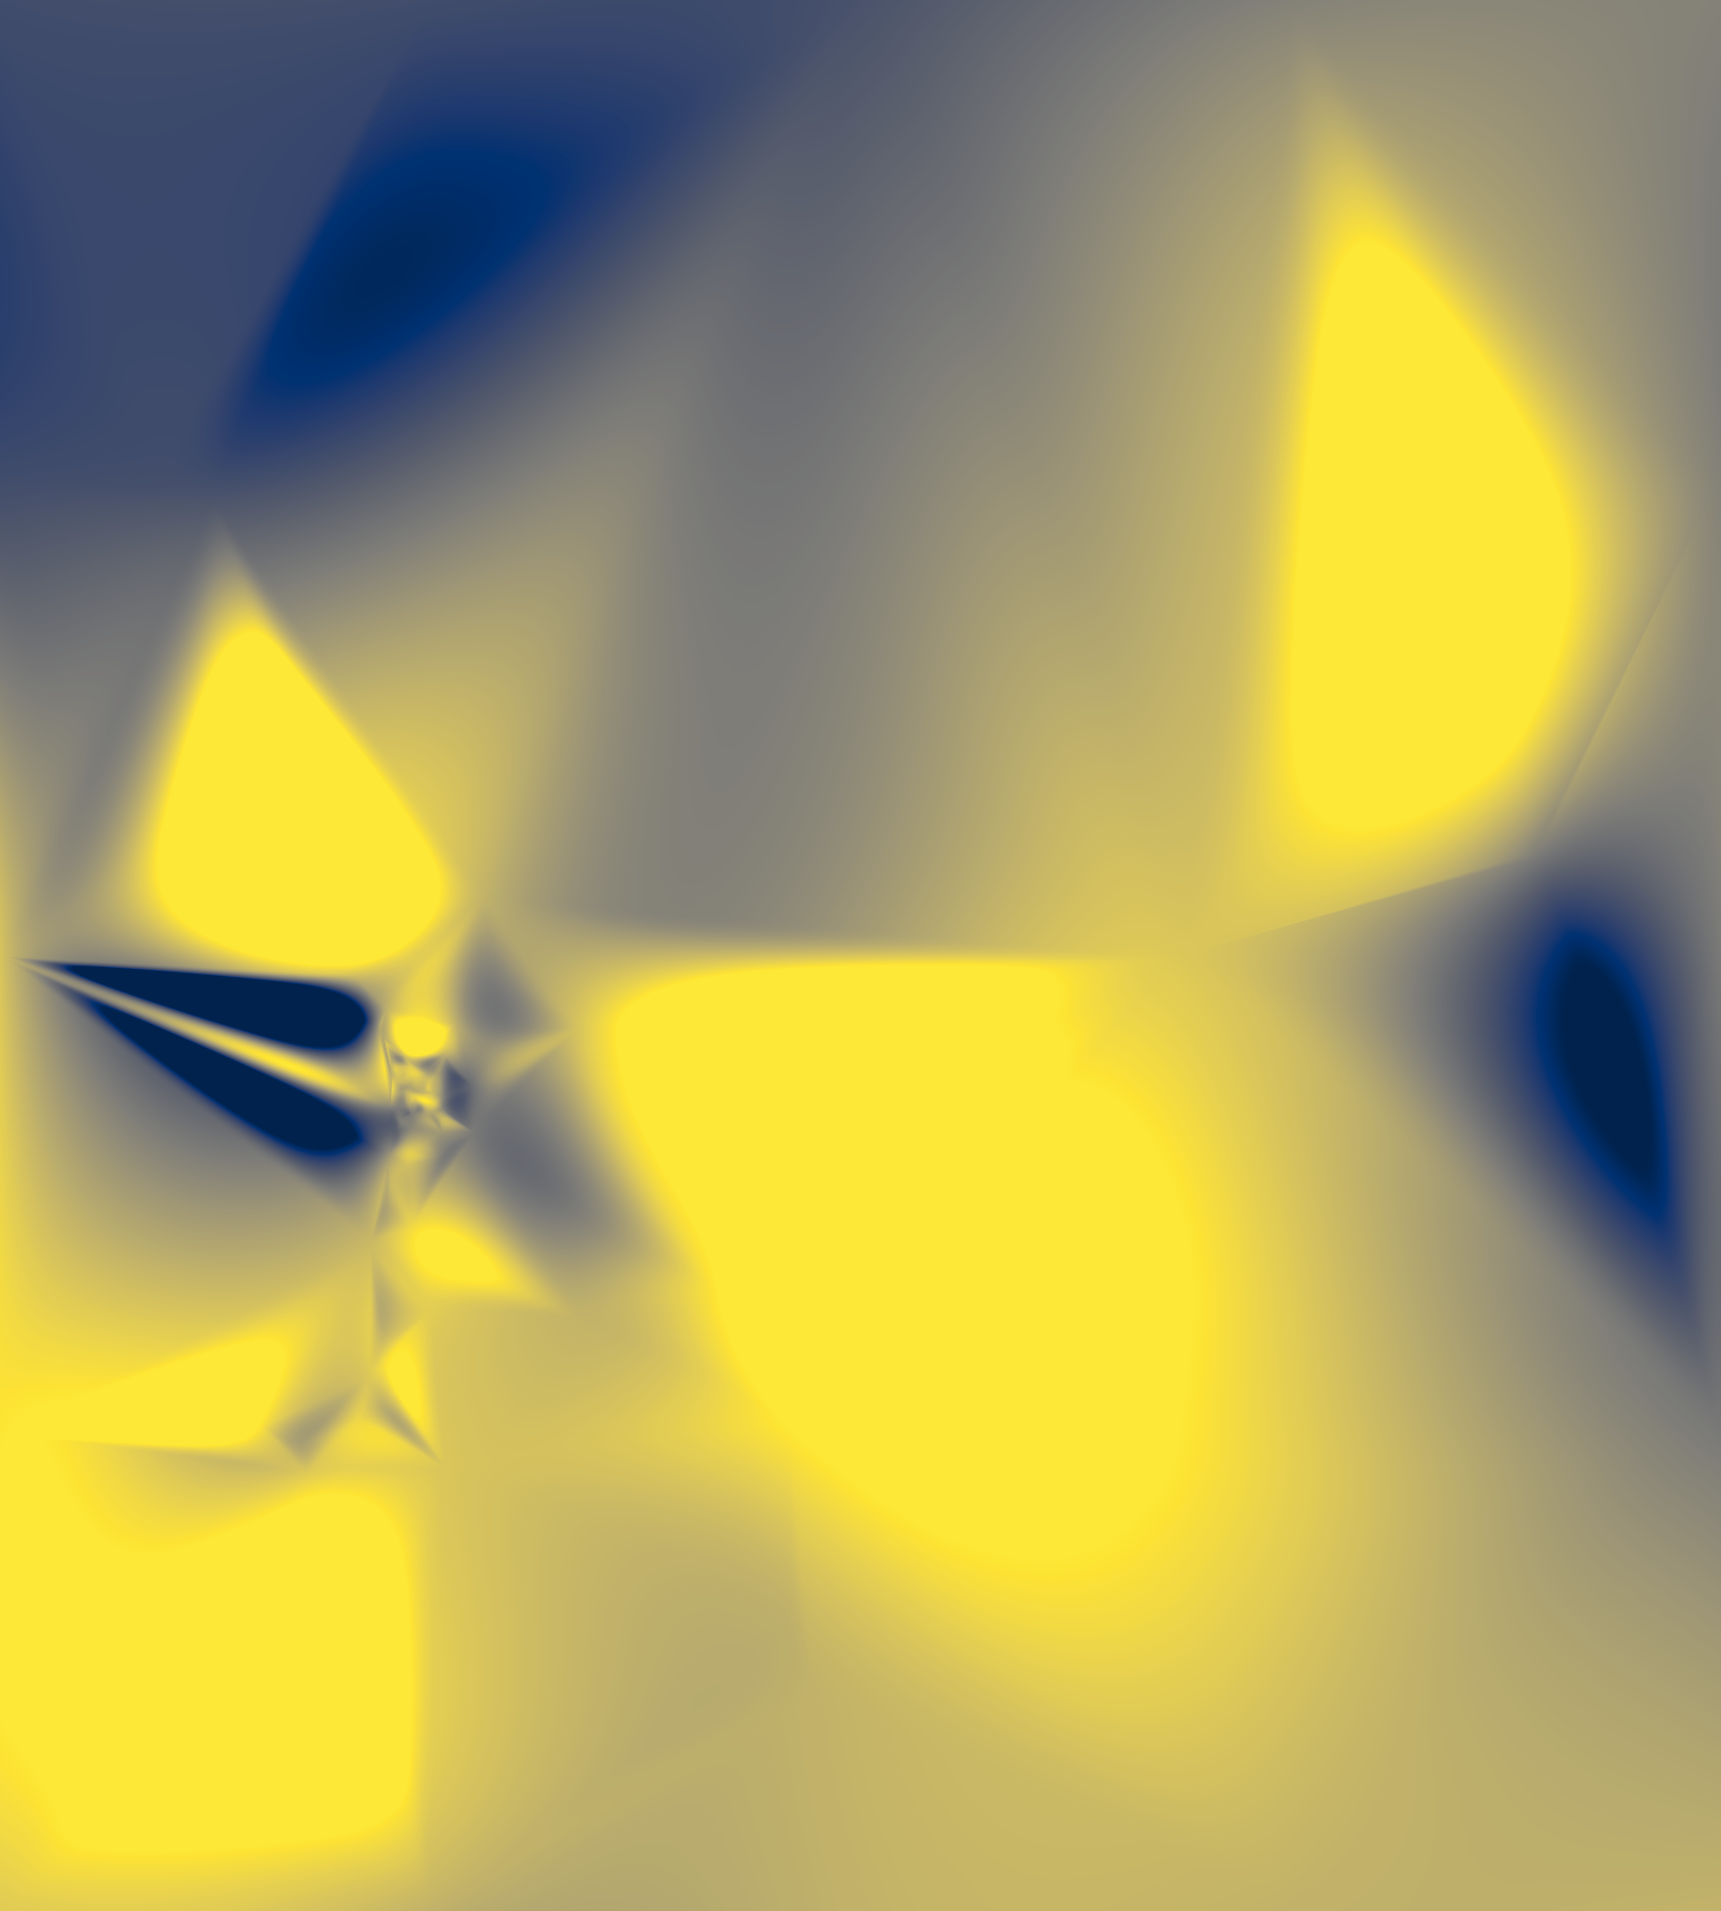

In [21]:
# Display the image
image_gen.image

In [22]:
# image_gen.save_image("example_image.png")

---

### Extract fitted values

For many applications we may not be interested in the visual image; rather, we want to use the values that result from fitting a surface to the source and boundary points.

We can retrieve the full 2D array covering the entire area.  It is important to remember that this is a grid specified by our `x_range` and `y_range`, having our specified `resolution`.

In [23]:
image_gen.fitted_values

array([[0.88474042, 0.88565317, 0.8865621 , ..., 0.24172089, 0.24204213,
        0.24236209],
       [0.88503143, 0.88595445, 0.88686587, ..., 0.24183952, 0.24215621,
        0.24247471],
       [0.88531976, 0.88624753, 0.88718243, ..., 0.24195145, 0.24226765,
        0.24258687],
       ...,
       [0.77487064, 0.77447063, 0.77407151, ..., 0.5332016 , 0.53336246,
        0.53352232],
       [0.77493508, 0.77453383, 0.77413311, ..., 0.53303019, 0.53319441,
        0.53335803],
       [0.77499951, 0.77459658, 0.77419364, ..., 0.53285997, 0.53302685,
        0.53319372]])

Alternatively, we can just retrieve values for a specific set of points:

In [24]:
# Get our original source points as an array of [(x, y), ... ]
points = []
for pc in postcodes:
    [lon, lat] = latlons.loc[pc, ['lon', 'lat']]
    points.append([lon, lat])

# Get fitted values for these specific points
fitted_point_values = image_gen.get_fitted_point_values(points)

# Display five example points
fitted_point_values[5:10]

[0.5943320960817262,
 0.7793631283869717,
 0.7614453224509015,
 0.6756600652635655,
 0.9164252522261093]

In [27]:
scaled['6000']['2020-02-20 13:00:00+08:00']

0.7294099515109841